# Hometask №8
## by Anton Kondrashov
##### HSE, CS, BSE 141(1)

In [1]:
import sklearn
from sklearn.svm import SVC
import pandas as pd
import matplotlib .pyplot as plt
import numpy as np
from math import exp, log
import Levenshtein
% matplotlib inline

## Preparations

In [2]:
def learn_stat(train_data, train_labels, test_data, test_labels, kernel, C):
    svm = SVC(C=C, kernel=kernel)
    svm.fit(train_data,train_labels)
    
    train_score = svm.score(train_data, train_labels)
    test_score = svm.score(test_data, test_labels)
    support = len(svm.support_vectors_)
    
    return (train_score, test_score, support)

In [3]:
def plot_stat(train_data, train_labels, test_data, test_labels, kernel, minC, maxC, steps):
    data = [[c] + list(learn_stat(train_data, train_labels, test_data, test_labels, kernel, c)) for c in np.logspace(log(minC, 10), log(maxC, 10), steps)]
    plt.figure(1)
    plt.plot([x[0] for x in data], [x[1] for x in data], 'bo-', )
    plt.xlabel('C')
    plt.ylabel('Train accuracy')
    plt.ylim((0., 1.))
    plt.figure(2)
    plt.plot([x[0] for x in data], [x[2] for x in data], 'bo-')
    plt.ylabel('Test accuracy')
    plt.xlabel('C')
    plt.ylim((0., 1.))
    plt.figure(3)
    plt.plot([x[3] for x in data], [x[0] for x in data], 'ro-')
    plt.ylabel('C')
    plt.xlabel('Support vectors number')
    plt.show()

In [83]:
def plot_support(train_data, train_labels, test_data, test_labels, kernel, C):
    train_data, train_labels = np.array(train_data), np.array(train_labels)
    test_data, test_labels = np.array(test_data), np.array(test_labels)
    svc = SVC(kernel=kernel, C=C)
    svc.fit(train_data, train_labels)
    sv = train_data[svc.support_]
    plt.scatter(test_data[:,0], test_data[:,1], c=test_labels, alpha=0.6, marker='o', s=100)
    plt.scatter(sv[:, 0], sv[:, 1], s=200, marker='x', c='g')
    X1, X2 = np.meshgrid(
        np.linspace(
            min(test_data[:, 0]) - 2,
            max(test_data[:, 0]) + 0.5,
            500
        ),
        np.linspace(
            min(test_data[:, 1]) - 0.5,
            max(test_data[:, 1]) + 1,
            500
        )
    )
    X3 = np.zeros((X1.shape[0], X1.shape[1], 2))
    X3[:, :, 0] = X1
    X3[:, :, 1] = X2
    ans = np.zeros(X1.shape)
    for i in range(len(X1)):
        ans[:, i] = svc.predict(X3[:, i, :])
    plt.contourf(X1, X2, ans, alpha=0.2)

## The task

In [84]:
#1
data = pd.read_csv('data/synth_train.csv', header=None)
X, Y = data[[1, 2]], data[0]
data_test = pd.read_csv('data/synth_test.csv', header=None)
X_test, Y_test = data_test[[1, 2]], data_test[0]

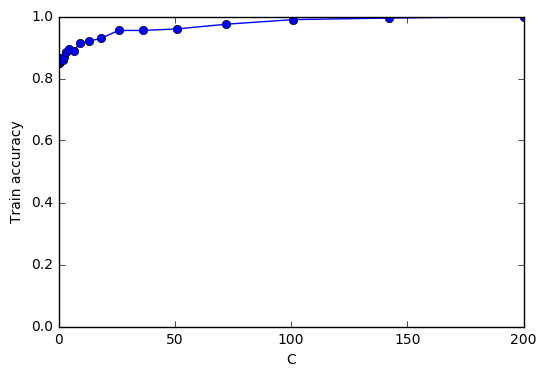

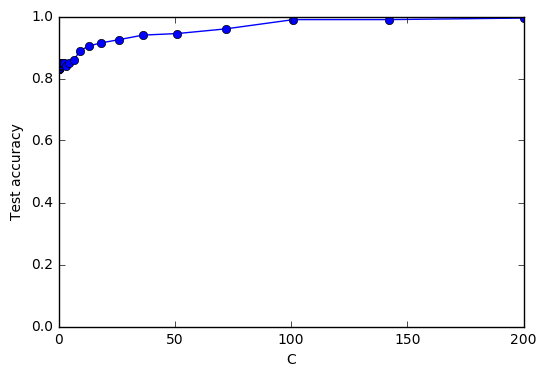

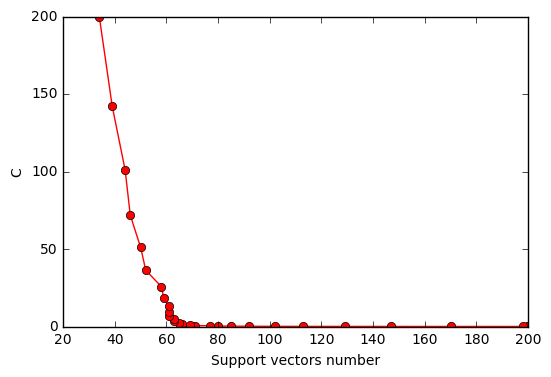

In [85]:
#2
# RBF kernel
plot_stat(X, Y, X_test, Y_test, 'rbf', 1./100, 200., 30)

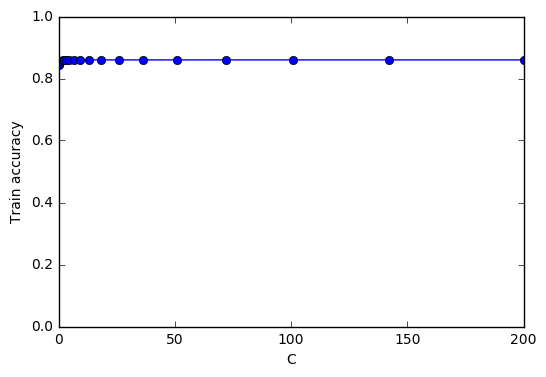

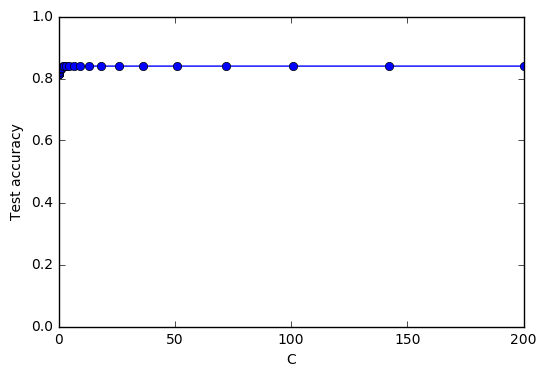

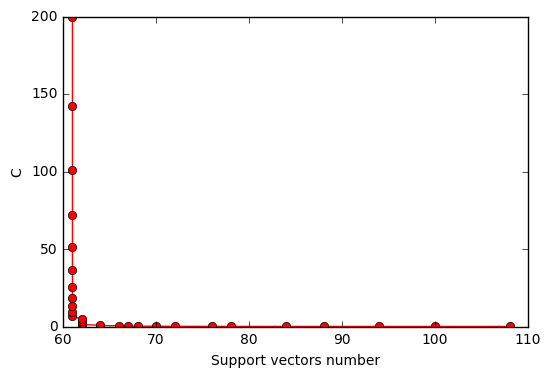

In [86]:
#linear kernel
plot_stat(X, Y, X_test, Y_test, 'linear', 1./100, 200., 30)

### Conclusion
a) Accuracy improves with larger C and on RBF it looks like model gets overfitted with large C. The larger C the more support vectors.

b) Common things are in a. The difference is in form of plots made. RBF dependencies on C/accuracy and C/suport vectors number looks less linear than for linear kernel.

c) The connection of train and test accuracies is obvious from plots of dependency C/accuracy. Accuracy improves simultaneously on both datasets.

d) It's a bad idea to find optimal value of C on train set. The model will be overfitted. The good idea is to use cross-validation.

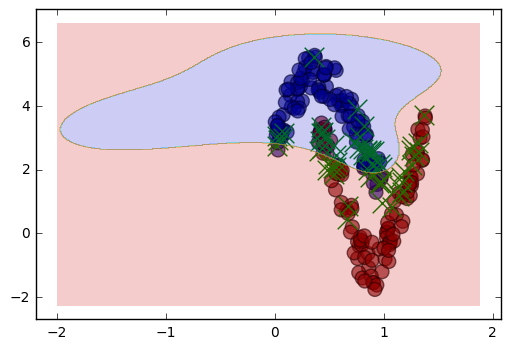

In [87]:
#3 
plot_support(X, Y, X_test, Y_test, 'rbf', 10)

The vectors are located like this because these objects are between the large parts of space filled with objects of one class.

## Kernel for strings

In [76]:
def get_clean_data(filename):
    data = set()
    for word in open(filename):
        data.add(word.strip())
    return list(data)

def marked_data():
    d1, d2 = get_clean_data('data/en.txt'), get_clean_data('data/fr.txt')
    d1_copy = d1[:]
    for w1 in d1_copy:
        if w1 in d2:
            d1.remove(w1)
            
    data = np.array([(w, 0) for w in d1] + [(w, 1) for w in d2])
    np.random.shuffle(data)
    return data

def index_data(data, train_length=400, test_length=400):
    train_words = np.arange(0, train_length).reshape(train_length, 1)
    train_lang = data[:train_length, 1]
    test_words = np.arange(train_length,train_length + test_length).reshape(test_length, 1)
    test_lang = data[train_length: train_length + test_length, 1]
    return (train_words, train_lang, test_words, test_lang)

In [110]:
def levenstein_kernel(data_1, data_2):
    n = data_1.shape[0]
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            matrix[i][j] = Levenshtein.distance(data[int(data_1[i][0])][0], data[int(data_2[j][0])][0])
    return matrix

def word_to_num(word):
    return sum([ord(c) for c in word])

def linked_words_to_num(element):
    return word_to_num(data[int(element)][0])

def linear_kernel(data_1, data_2):
    f = np.vectorize(linked_words_to_num)
    data_1 = f(data_1)
    data_2 = f(data_2)
    return data_1.dot(data_2.T)

def kernel_sum(kernel_1, kernel_2, data_1, data_2):
    return kernel_1(data_1, data_2) + kernel_2(data_1, data_2)

def kernel_prod(kernel_1, kernel_2, data_1, data_2):
    return kernel_1(data_1, data_2) * kernel_2(data_1, data_2)

def final_kernel(data_1, data_2):
    return kernel_sum(linear_kernel, levenstein_kernel, data_1, data_2)

In [111]:
data = marked_data()
train_words, train_lang, test_words, test_lang = index_data(data)

In [114]:
for c in np.logspace(log(1. / 100, 10), log(200, 10), 5):
    clf = SVC(kernel=levenstein_kernel, C=c)
    clf.fit(train_words, train_lang)
    print(clf.score(test_words, test_lang))

0.46
0.4725
0.475
0.475
0.4775
